In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
transform = transforms.ToTensor()

In [18]:
train_data = datasets.MNIST(root='Data', train=True, download=False, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [19]:
test_data = datasets.MNIST(root='Data', train=False, download=False, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [20]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [21]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [22]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []
train_losses_graph = []
test_losses_graph = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_losses_graph.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    
    loss_t = criterion(y_val, y_test).item()
    test_losses_graph.append(loss_t)
    
    test_correct.append(tst_corr.item())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.30946591  accuracy:  83.585%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.16791894  accuracy:  87.945%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.14138491  accuracy:  89.788%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.22795951  accuracy:  94.960%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.25164887  accuracy:  95.183%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.13384342  accuracy:  95.418%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.15869436  accuracy:  96.600%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.07899343  accuracy:  96.665%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.07815251  accuracy:  96.738%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.15009296  accuracy:  97.380%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.19550936  accuracy:  97.395%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.02208382  accuracy:  97.448%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.07289968  accuracy:  98.145%
epoch:  4  b

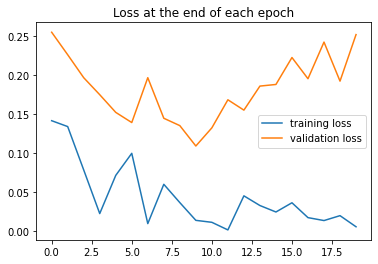

In [25]:
plt.plot(train_losses_graph, label='training loss')
plt.plot(test_losses_graph, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [26]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1]*100/10000:.3f}%') # print the most recent result as a percent

[9482, 9604, 9650, 9688, 9724, 9766, 9703, 9783, 9774, 9749, 9779, 9778, 9774, 9785, 9760, 9743, 9785, 9770, 9759, 9770]

Test accuracy: 97.700%


In [27]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9770/10000 =  97.700%


In [29]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    6    2    0    2    1    0    5    1]
 [   0 1125    2    0    0    0    2    4    0    2]
 [   0    0 1001    2    4    0    0   13    2    0]
 [   2    3    1  970    0    2    1    0    2    2]
 [   1    0    1    1  964    1    1    2    3   20]
 [   0    0    0   19    0  878    4    1    9    8]
 [   1    3    3    0    9    7  949    0    2    0]
 [   1    1   10    6    1    1    0 1003    3    9]
 [   3    3    7    5    1    0    0    3  947    6]
 [   0    0    1    5    3    1    0    2    1  961]]


In [30]:
# 1. deney test accuracy = 97,49